<a href="https://colab.research.google.com/github/elaine-chenma/heart-disease-classification/blob/master/Diagnosing_Heart_Disease_with_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diagnosing Heart Disease with Classification Models

## Data Source

Data source: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Data Analysis Plan

In [5]:
from IPython.display import Image
from google.colab import files
uploaded = files.upload()

Saving Canvas.jpg to Canvas (1).jpg
Saving Canvas2.jpg to Canvas2.jpg


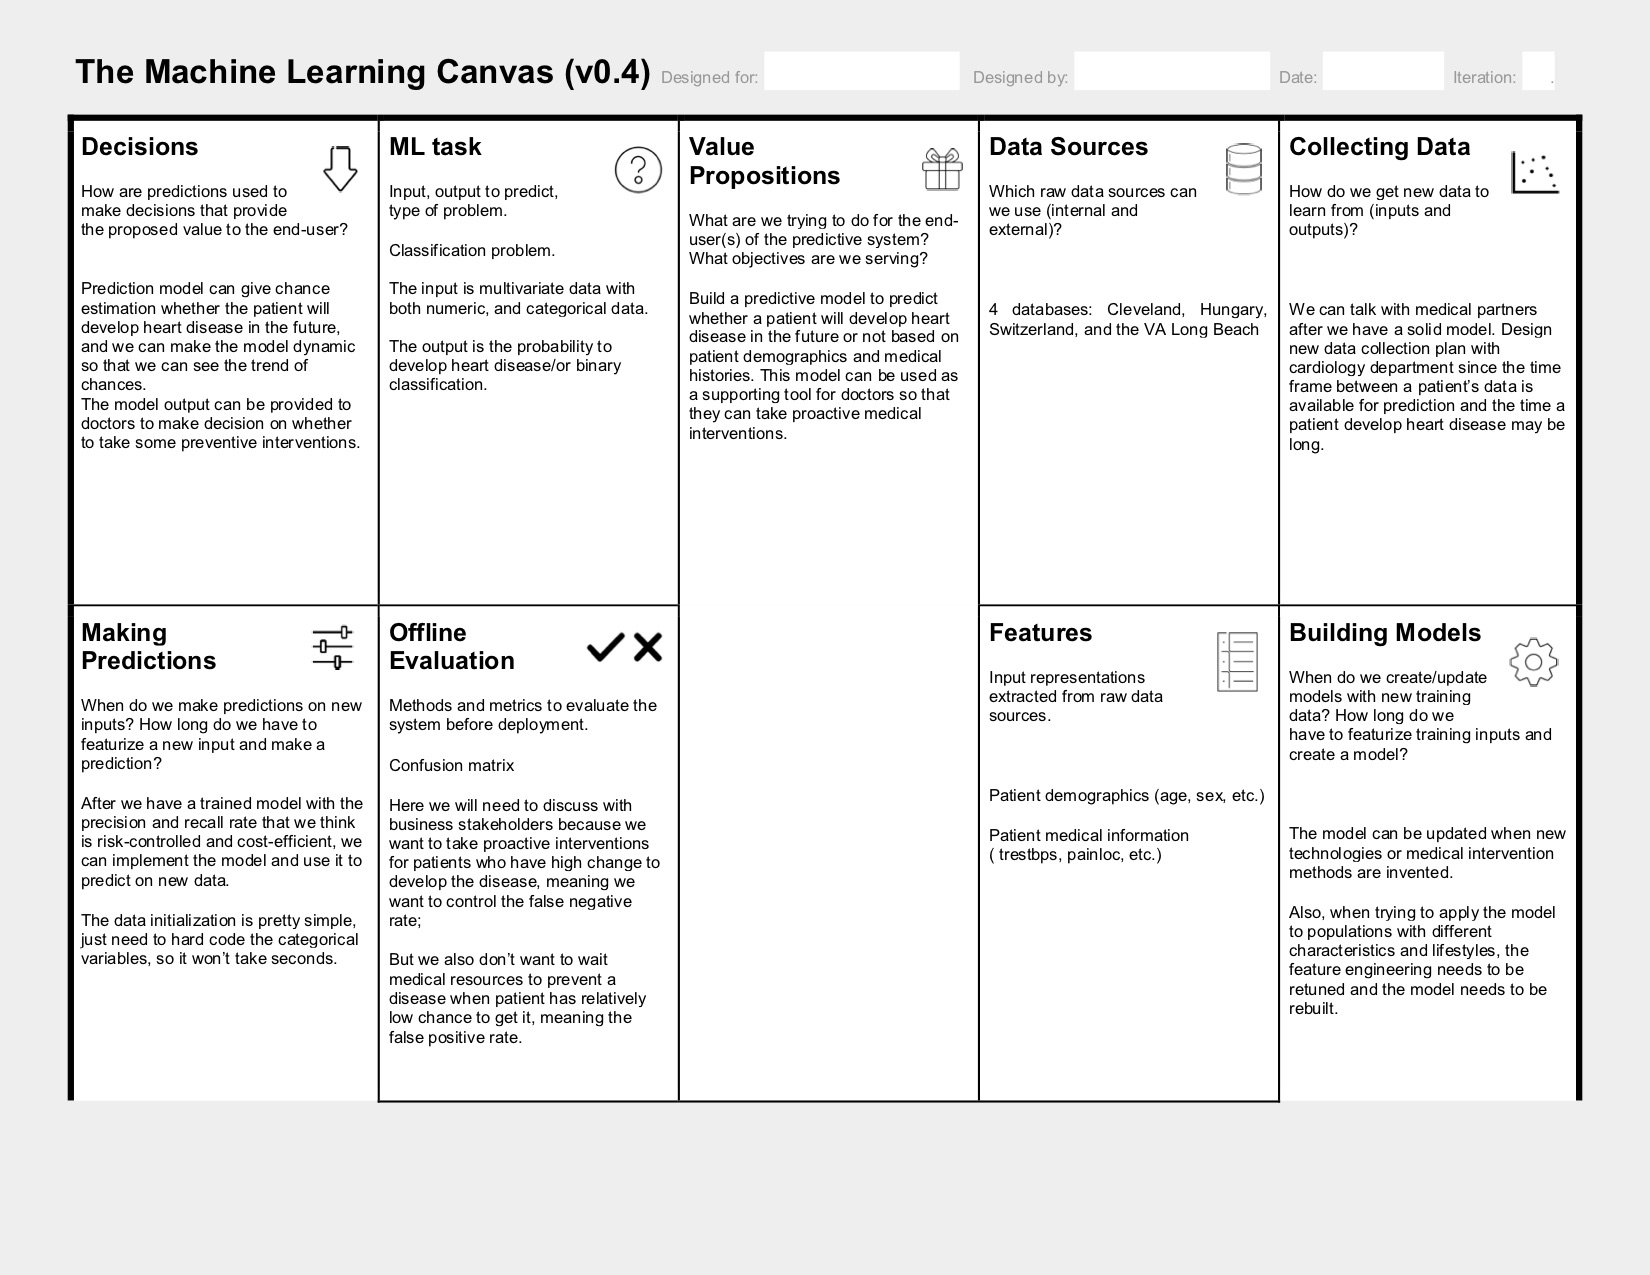

In [11]:
Image("Canvas.jpg", width=1000)

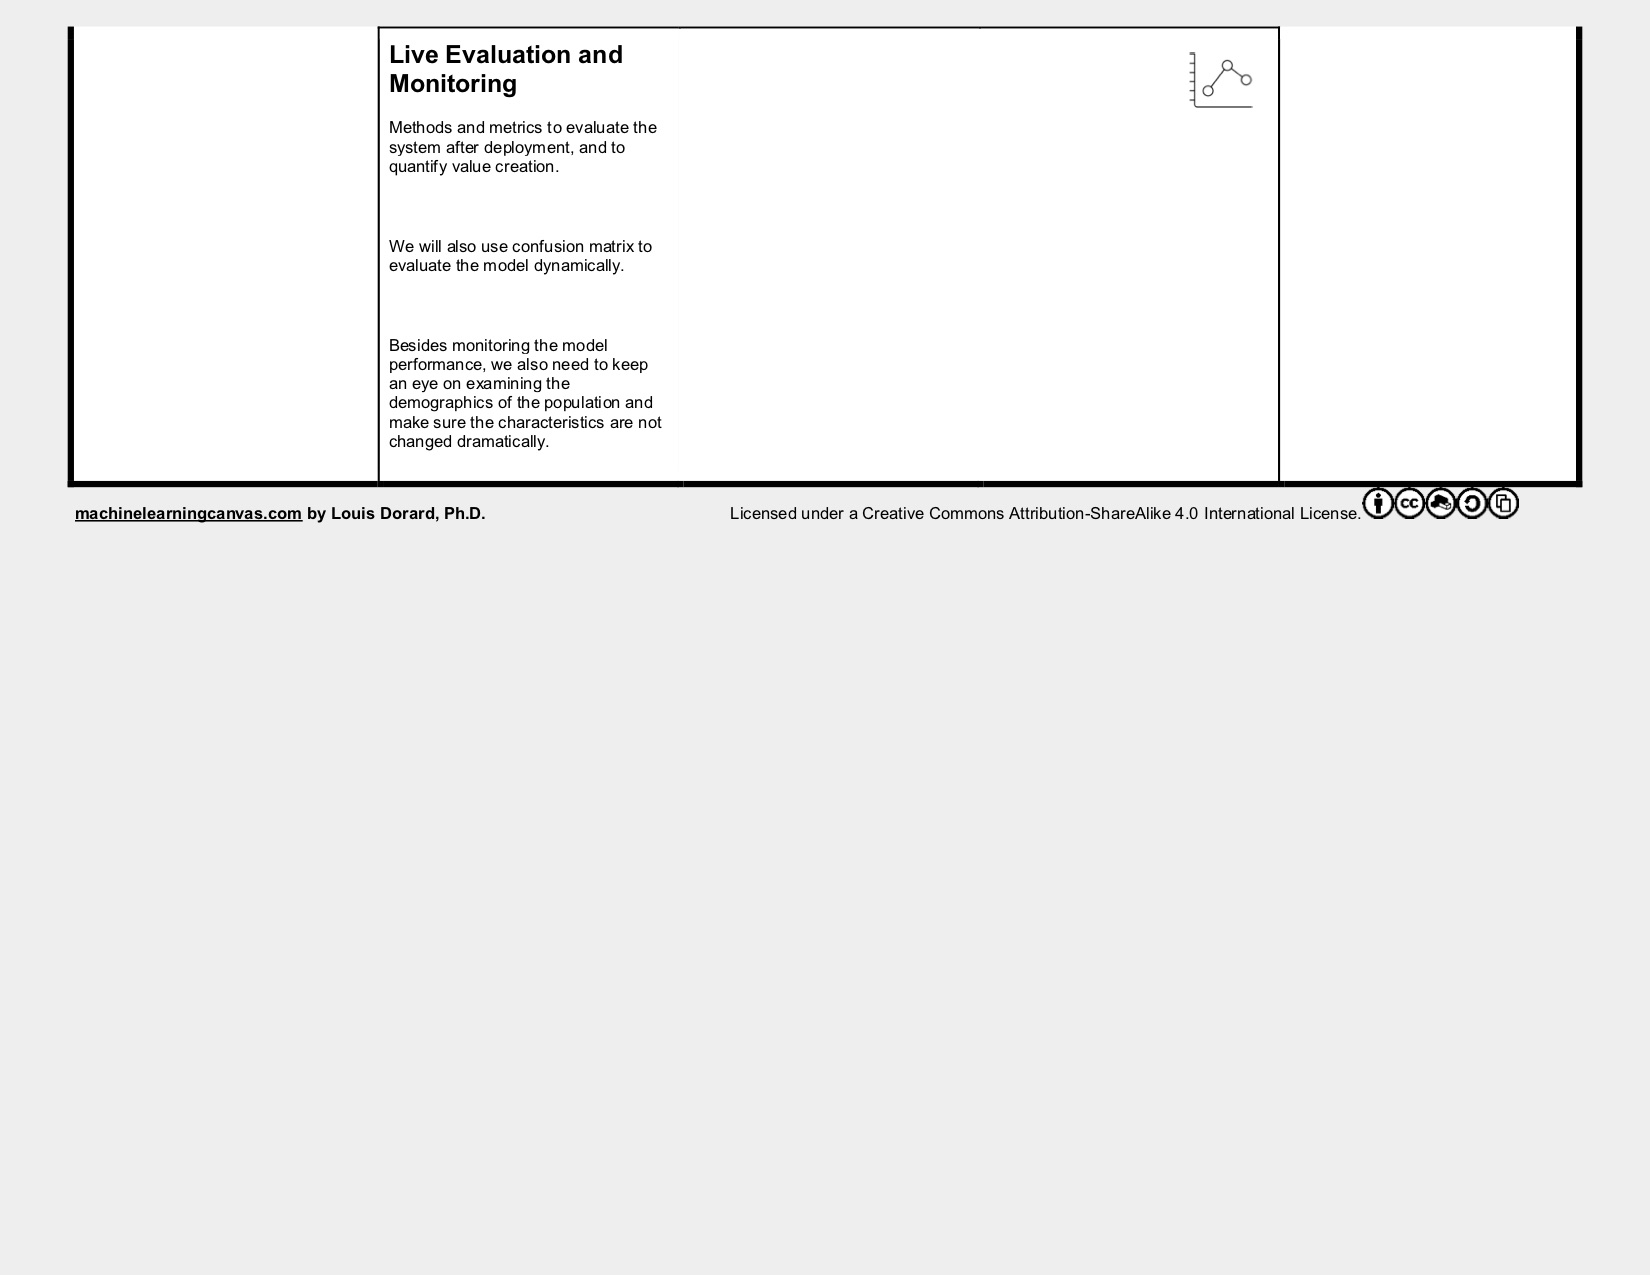

In [12]:
Image("Canvas2.jpg", width=1000)

## 1. Import data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from yellowbrick.classifier import ROCAUC


np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
disease = pd.read_csv('https://raw.githubusercontent.com/elaine-chenma/heart-disease-classification/master/data/heart.csv')

In [0]:
disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


** Rename the columns and transoform the values to words for easier interpretation.**

In [0]:
disease.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [0]:
disease['sex'][disease['sex'] == 0] = 'female'
disease['sex'][disease['sex'] == 1] = 'male'

disease['chest_pain_type'][disease['chest_pain_type'] == 1] = 'typical angina'
disease['chest_pain_type'][disease['chest_pain_type'] == 2] = 'atypical angina'
disease['chest_pain_type'][disease['chest_pain_type'] == 3] = 'non-anginal pain'
disease['chest_pain_type'][disease['chest_pain_type'] == 4] = 'asymptomatic'

disease['fasting_blood_sugar'][disease['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
disease['fasting_blood_sugar'][disease['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

disease['rest_ecg'][disease['rest_ecg'] == 0] = 'normal'
disease['rest_ecg'][disease['rest_ecg'] == 1] = 'ST-T wave abnormality'
disease['rest_ecg'][disease['rest_ecg'] == 2] = 'left ventricular hypertrophy'

disease['exercise_induced_angina'][disease['exercise_induced_angina'] == 0] = 'no'
disease['exercise_induced_angina'][disease['exercise_induced_angina'] == 1] = 'yes'

disease['st_slope'][disease['st_slope'] == 1] = 'upsloping'
disease['st_slope'][disease['st_slope'] == 2] = 'flat'
disease['st_slope'][disease['st_slope'] == 3] = 'downsloping'

disease['thalassemia'][disease['thalassemia'] == 1] = 'normal'
disease['thalassemia'][disease['thalassemia'] == 2] = 'fixed defect'
disease['thalassemia'][disease['thalassemia'] == 3] = 'reversable defect'

In [0]:
disease['sex'] = disease['sex'].astype('object')
disease['chest_pain_type'] = disease['chest_pain_type'].astype('object')
disease['fasting_blood_sugar'] = disease['fasting_blood_sugar'].astype('object')
disease['rest_ecg'] = disease['rest_ecg'].astype('object')
disease['exercise_induced_angina'] = disease['exercise_induced_angina'].astype('object')
disease['st_slope'] = disease['st_slope'].astype('object')
disease['thalassemia'] = disease['thalassemia'].astype('object')

In [0]:
disease.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,non-anginal pain,145,233,greater than 120mg/ml,normal,150,no,2.3,0,0,normal,1
1,37,male,atypical angina,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,0,0,fixed defect,1
2,41,female,typical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,flat,0,fixed defect,1
3,56,male,typical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,flat,0,fixed defect,1
4,57,female,0,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,flat,0,fixed defect,1


## 2. EDA

### First, since this is a classificatio problem, let's check whether it's balanced.

Seems pretty balanced.

In [0]:
disease.target.value_counts()

1    165
0    138
Name: target, dtype: int64

### Let's exam some of our assumptions

#### 2.1 Age and Sex will have a relationsihp with heart disease

The bar plot below shows that as age grows, people without heart disease out grows people with heart disease, which is counter-intuitive. 

Text(0.5,1,'heart disease value counts and age')

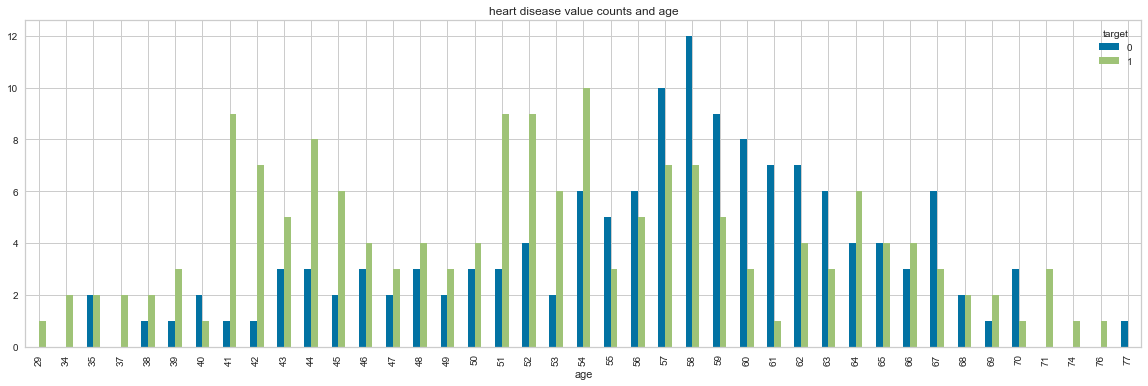

In [0]:
pd.crosstab(disease['age'], disease['target']).plot(kind = 'bar', figsize=(20,6))
plt.title('heart disease value counts and age')

This plot shows that female has a higher rate of heart disease than male.


Text(0.5,1,'heart disease value counts and sex')

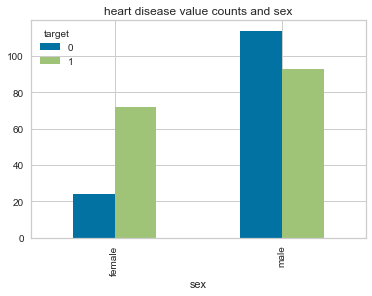

In [0]:
pd.crosstab(disease['sex'], disease['target']).plot(kind = 'bar')
plt.title('heart disease value counts and sex')

### 2.2 Check categorical variables

**chest pain type**

We can see the chest pain type is correltaed with heart disease, when there is no chest pain, there is higher probability that the patient does not has heart disease.

Text(0.5,1,'heart disease value counts and chest pain type')

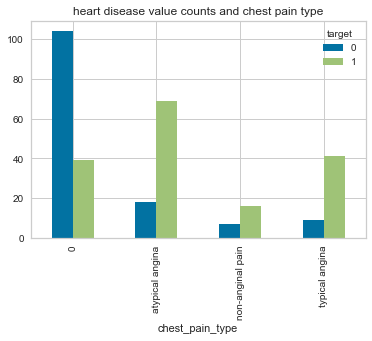

In [0]:
pd.crosstab(disease.chest_pain_type, disease.target).plot(kind='bar')
plt.title('heart disease value counts and chest pain type')

**fasting blood sugar**

The relationship between fasting_blood_sugar and heart disease is quite counter-intuitive: We speculate that people with higher fasting_blood_sugar will have higher probability of getting heart disease, while the data shows the opposite.

Text(0.5,1,'heart disease value counts and fasting blood sugar')

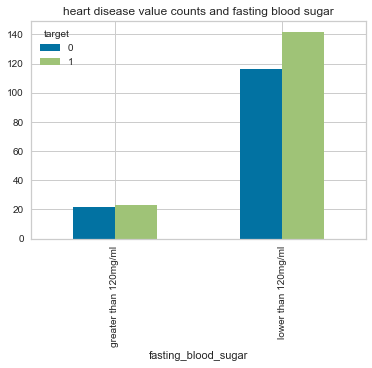

In [0]:
pd.crosstab(disease.fasting_blood_sugar,disease.target).plot(kind='bar')
plt.title('heart disease value counts and fasting blood sugar')

**rest ecg**

The abnormality in ECG has great relationship with heart disease, which is quite reasonale, because ECG is a method to detect heart disease.

Text(0.5,1,'heart disease value counts and rest_ecg')

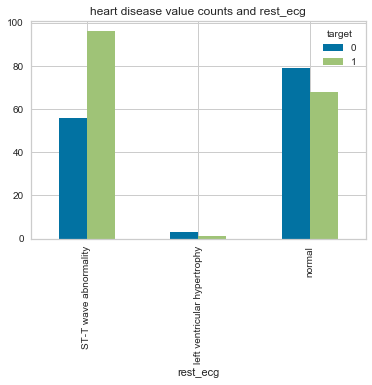

In [0]:
pd.crosstab(disease.rest_ecg,disease.target).plot(kind='bar')
plt.title('heart disease value counts and rest_ecg')

**exercise_induced_angina**

Text(0.5,1,'heart disease value counts and exercise_induced_angina')

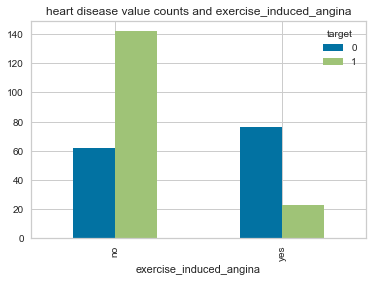

In [0]:
pd.crosstab(disease.exercise_induced_angina,disease.target).plot(kind='bar')
plt.title('heart disease value counts and exercise_induced_angina')

**thalassemia**

Text(0.5,1,'heart disease value counts and thalassemia')

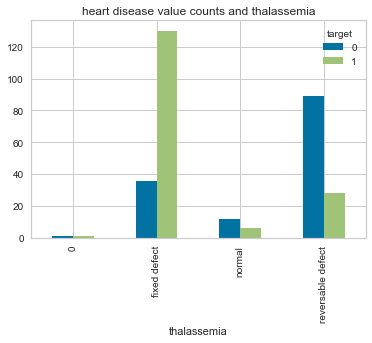

In [0]:
pd.crosstab(disease.thalassemia,disease.target).plot(kind='bar')
plt.title('heart disease value counts and thalassemia')

### 2.3 Check the numerical variables

From the heatmap below, we can see that among the numerical variables, num_major_vessels and st_depression has negative relationship with heart disease; While max_heart_rate_achieved has positive relationship, which makes sense in that this metric indicates the status a patient is admitted. Age, resting_blood_pressure and cholesterol show no correlation with heart disease from correlation matrix.

Text(0.5,1,'heatmap')

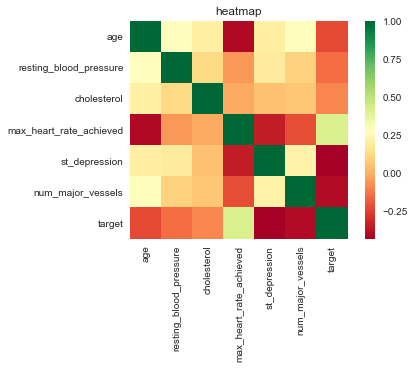

In [0]:
sns.heatmap(disease.corr(), square=True, cmap='RdYlGn')
plt.title('heatmap')


## 3. Data Transformation

We will hard code categorical variables for sklearn ml models, discard the first dummy variables.


In [0]:
disease_dt = pd.get_dummies(disease, drop_first=True)

In [0]:
disease_dt.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect,target_1
0,63,145,233,150,2.3,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1
1,37,130,250,187,3.5,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1
2,41,130,204,172,1.4,0,0,0,0,1,1,0,1,0,1,0,1,0,0,1
3,56,120,236,178,0.8,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1
4,57,120,354,163,0.6,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1


**Split dataset to training and testing**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(disease_dt.drop('target_1', 1), disease_dt['target_1'], test_size = .2) #split the data


## 4. modeling
### 4.1 Logistic Regression

**Fit the model**

In [0]:
# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Grid Search for Logistic Regression

In [0]:
# Create Hyperparameter Search Space
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [0]:
# Create Grid Search
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

In [0]:
clf

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
# Conduct Grid Search
# Fit grid search
best_model = clf.fit(X_train, y_train)

In [0]:
# View Hyperparameter Values Of Best Model
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


In [0]:
# Predict Using Best Model
# Predict target vector
y_pred_log = best_model.predict(X_test)
y_pred_log[:5]

array([1, 0, 0, 0, 1])

#### **Confusion matrix, precision, recall**

In [0]:
# Compute and print the confusion matrix and classification report
confusion_mat = confusion_matrix(y_test, y_pred_log)
confusion_mat


array([[24,  6],
       [ 7, 24]])

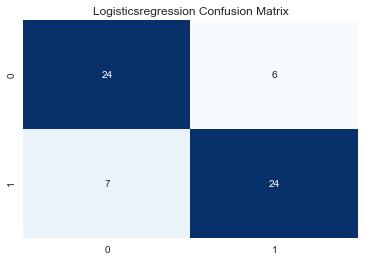

In [0]:
plt.title("Logisticsregression Confusion Matrix")
sns.heatmap(confusion_mat,annot=True,cmap="Blues",fmt="d",cbar=False)

#### AUC, ROC

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail



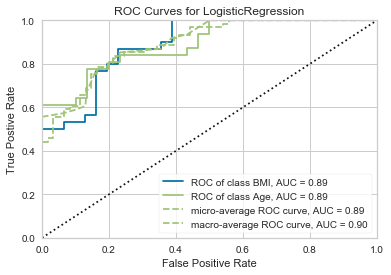

In [0]:
classes = ["BMI", "Age"]
# Instantiate the visualizer with the classification model
visualizer = ROCAUC(LogisticRegression(), classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [0]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_log)
auc(fpr, tpr)

0.7870967741935484

### SVM

We have divided the data into training and testing sets. Now is the time to train our SVM on the training data. Scikit-Learn contains the svm library, which contains built-in classes for different SVM algorithms. Since we are going to perform a classification task, we will use the support vector classifier class, which is written as SVC in the Scikit-Learn's svm library. This class takes one parameter, which is the kernel type. This is very important. In the case of a simple SVM we simply set this parameter as "linear" since simple SVMs can only classify linearly separable data. We will see non-linear kernels in the next section.

The fit method of SVC class is called to train the algorithm on the training data, which is passed as a parameter to the fit method. Execute the following code to train the algorithm:

In [0]:
svm = SVC(kernel='linear')  
svm.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
#Grid Search
parameters = {'kernel':('linear', 'rbf'), 'C':(1,0.25,0.5,0.75),'gamma': (1,2,3,'auto'),'decision_function_shape':('ovo','ovr'),'shrinking':(True,False)}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': (1, 0.25, 0.5, 0.75), 'gamma': (1, 2, 3, 'auto'), 'decision_function_shape': ('ovo', 'ovr'), 'shrinking': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
clf.best_params_

{'C': 0.25,
 'decision_function_shape': 'ovo',
 'gamma': 1,
 'kernel': 'linear',
 'shrinking': True}

In [0]:
y_pred_SVC = svm.predict(X_test)  
y_pred_SVC

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0])

** Confusion matrix, precision, recall **

** AUC, ROC**

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_SVC)
auc(fpr, tpr)

0.803763440860215

### Random Forest Classifier


In [0]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 500}

In [0]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='gini')

In [0]:

rfc1.fit(X_train, y_train)

y_pred_rf=rfc1.predict(X_test)
y_pred_rf

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1])

** Confusion matrix, precision, recall **

** AUC, ROC**

Another common metric is the Area Under the Curve, or AUC. This is a convenient way to capture the performance of a model in a single number, although it's not without certain issues. As a rule of thumb, an AUC can be classed as follows,

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail



In [0]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
auc(fpr, tpr)

0.8026881720430108

## Model Comparison, Logistic Regression vs. SVM vs. Random Forest

Below table is the model performance of three models obtained with GridSearch with 5 folds. We can see that **Random Forest outperforms the other models on Precisision and AUC. While SVM outperforms other models on Recall.**



|Indicators | LogisticRegression|  SVM|  Random Forest|
| ------------- |-------------|------------- |-------------|
|Precision| 0.77|0.78|0.82|
|Recalls |0.80|0.83|0.79|
|AUC| 0.79|0.80|0.80|


In the case of identifying high-risk population, we think **false negative error(Recall) is more important than false positive (Precision).** Fail to diagnose heart disease for a patient will pose life danger to the patient, and miss the medical cure time interval. While if we diagnose a patient with heart disease, we can run second round of test to double check whether this is false positive, and the probability that two rounds of tests both result in false positive is very small.

## H2O AutoML

In [0]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()
# ingest data into H2O
df = h2o.import_file('https://raw.githubusercontent.com/elaine-chenma/heart-disease-classification/master/data/heart.csv')

#Define x and y columns
x = df.columns
y='target'

x.remove(y)

# Convert y column into factors
df[y] = df[y].asfactor()

# Split data into training and validation
train, valid = df.split_frame(ratios = [.8], seed = 1234)                     

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 27 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.3
H2O cluster version age:,1 day
H2O cluster name:,H2O_from_python_machen_ad1k2a
H2O cluster total nodes:,1
H2O cluster free memory:,3.993 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# Using AutoML to train the model
aml = H2OAutoML(max_models = 10, max_runtime_secs=999999999)
aml.train(x=x, y=y, training_frame = train, validation_frame = valid)

# Review AutoML result
lb = aml.leaderboard
lb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190508_111146,0.916771,0.371611,0.156639,0.342503,0.117308
XGBoost_3_AutoML_20190508_100621,0.915514,0.384169,0.157652,0.34607,0.119765
GBM_3_AutoML_20190508_111146,0.913417,0.367106,0.159679,0.337454,0.113875
GBM_2_AutoML_20190508_100621,0.910273,0.375499,0.174493,0.344313,0.118552
XGBoost_3_AutoML_20190508_111146,0.910238,0.388452,0.18225,0.349339,0.122038
GBM_3_AutoML_20190508_100621,0.909364,0.376301,0.194724,0.346354,0.119961
StackedEnsemble_BestOfFamily_AutoML_20190508_100621,0.908106,0.385932,0.17079,0.348831,0.121683
XGBoost_1_AutoML_20190508_100621,0.907617,0.382077,0.172816,0.34804,0.121132
GBM_2_AutoML_20190508_111146,0.906359,0.381209,0.175856,0.347762,0.120939
StackedEnsemble_AllModels_AutoML_20190508_100621,0.903494,0.391442,0.178546,0.351294,0.123407


In [0]:
# Winning Model
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190508_111146


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09119761096129772
RMSE: 0.3019894219360965
LogLoss: 0.3051713303690641
Mean Per-Class Error: 0.1074423480083857
AUC: 0.9517120894479385
pr_auc: 0.9458382537372736
Gini: 0.903424178895877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5851063132286072: 


,0,1,Error,Rate
0,95.0,11.0,0.1038,(11.0/106.0)
1,15.0,120.0,0.1111,(15.0/135.0)
Total,110.0,131.0,0.1079,(26.0/241.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5851063,0.9022556,128.0
max f2,0.3190688,0.9361702,162.0
max f0point5,0.6172448,0.9154930,123.0
max accuracy,0.5851063,0.8921162,128.0
max precision,0.9804098,1.0,0.0
max recall,0.1297972,1.0,190.0
max specificity,0.9804098,1.0,0.0
max absolute_mcc,0.5851063,0.7823864,128.0
max min_per_class_accuracy,0.5851063,0.8888889,128.0
max mean_per_class_accuracy,0.5851063,0.8925577,128.0


Gains/Lift Table: Avg response rate: 56.02 %, avg score: 56.11 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0124481,0.9778820,1.7851852,1.7851852,1.0,0.9797721,1.0,0.9797721,0.0222222,0.0222222,78.5185185,78.5185185
,2,0.0207469,0.9756290,1.7851852,1.7851852,1.0,0.9766923,1.0,0.9785402,0.0148148,0.0370370,78.5185185,78.5185185
,3,0.0331950,0.9724967,1.7851852,1.7851852,1.0,0.9745915,1.0,0.9770594,0.0222222,0.0592593,78.5185185,78.5185185
,4,0.0414938,0.9661805,1.7851852,1.7851852,1.0,0.9685062,1.0,0.9753488,0.0148148,0.0740741,78.5185185,78.5185185
,5,0.0539419,0.9645256,1.7851852,1.7851852,1.0,0.9653915,1.0,0.9730509,0.0222222,0.0962963,78.5185185,78.5185185
,6,0.1037344,0.9553007,1.7851852,1.7851852,1.0,0.9604145,1.0,0.9669854,0.0888889,0.1851852,78.5185185,78.5185185
,7,0.1535270,0.9417021,1.7851852,1.7851852,1.0,0.9472800,1.0,0.9605945,0.0888889,0.2740741,78.5185185,78.5185185
,8,0.2033195,0.9197000,1.6364198,1.7487528,0.9166667,0.9288593,0.9795918,0.9528226,0.0814815,0.3555556,63.6419753,74.8752834
,9,0.3029046,0.8515046,1.7851852,1.7607306,1.0,0.8852495,0.9863014,0.9306068,0.1777778,0.5333333,78.5185185,76.0730594
,10,0.4024896,0.7703619,1.5620370,1.7115693,0.875,0.8116873,0.9587629,0.9011834,0.1555556,0.6888889,56.2037037,71.1569301




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1146279517905975
RMSE: 0.3385674996076816
LogLoss: 0.3684542797156956
Mean Per-Class Error: 0.109375
AUC: 0.9260416666666667
pr_auc: 0.8828616672323079
Gini: 0.8520833333333333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39047932624816895: 


,0,1,Error,Rate
0,25.0,7.0,0.2188,(7.0/32.0)
1,0.0,30.0,0.0,(0.0/30.0)
Total,25.0,37.0,0.1129,(7.0/62.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3904793,0.8955224,36.0
max f2,0.3904793,0.9554140,36.0
max f0point5,0.3904793,0.8426966,36.0
max accuracy,0.3904793,0.8870968,36.0
max precision,0.9535215,1.0,0.0
max recall,0.3904793,1.0,36.0
max specificity,0.9535215,1.0,0.0
max absolute_mcc,0.3904793,0.7958932,36.0
max min_per_class_accuracy,0.6169641,0.8125,30.0
max mean_per_class_accuracy,0.3904793,0.890625,36.0


Gains/Lift Table: Avg response rate: 48.39 %, avg score: 51.31 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0161290,0.9529762,2.0666667,2.0666667,1.0,0.9535215,1.0,0.9535215,0.0333333,0.0333333,106.6666667,106.6666667
,2,0.0322581,0.9525436,2.0666667,2.0666667,1.0,0.9526276,1.0,0.9530746,0.0333333,0.0666667,106.6666667,106.6666667
,3,0.0322581,0.9523108,0.0,2.0666667,0.0,0.0,1.0,0.9530746,0.0,0.0666667,-100.0,106.6666667
,4,0.0483871,0.9514833,2.0666667,2.0666667,1.0,0.9522460,1.0,0.9527984,0.0333333,0.1,106.6666667,106.6666667
,5,0.0645161,0.9497007,2.0666667,2.0666667,1.0,0.9505126,1.0,0.9522269,0.0333333,0.1333333,106.6666667,106.6666667
,6,0.1129032,0.8978356,2.0666667,2.0666667,1.0,0.9192171,1.0,0.9380799,0.1,0.2333333,106.6666667,106.6666667
,7,0.1612903,0.8621147,2.0666667,2.0666667,1.0,0.8752752,1.0,0.9192384,0.1,0.3333333,106.6666667,106.6666667
,8,0.2096774,0.8258890,2.0666667,2.0666667,1.0,0.8360629,1.0,0.9000441,0.1,0.4333333,106.6666667,106.6666667
,9,0.3064516,0.7423541,1.3777778,1.8491228,0.6666667,0.7884879,0.8947368,0.8648158,0.1333333,0.5666667,37.7777778,84.9122807
,10,0.4032258,0.6702879,1.3777778,1.736,0.6666667,0.6968256,0.84,0.8244982,0.1333333,0.7,37.7777778,73.6




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.11730849064502337
RMSE: 0.34250327099901307
LogLoss: 0.3716107545324757
Mean Per-Class Error: 0.15562543675751228
AUC: 0.9167714884696017
pr_auc: 0.9259976203615681
Gini: 0.8335429769392033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5130663514137268: 


,0,1,Error,Rate
0,83.0,23.0,0.217,(23.0/106.0)
1,13.0,122.0,0.0963,(13.0/135.0)
Total,96.0,145.0,0.1494,(36.0/241.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5130664,0.8714286,143.0
max f2,0.1637908,0.9196185,192.0
max f0point5,0.7777166,0.8655804,87.0
max accuracy,0.5336983,0.8506224,141.0
max precision,0.9775926,1.0,0.0
max recall,0.1637908,1.0,192.0
max specificity,0.9775926,1.0,0.0
max absolute_mcc,0.5130664,0.6962762,143.0
max min_per_class_accuracy,0.5842729,0.8207547,128.0
max mean_per_class_accuracy,0.5336983,0.8443746,141.0


Gains/Lift Table: Avg response rate: 56.02 %, avg score: 55.77 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0124481,0.9738701,1.7851852,1.7851852,1.0,0.9755856,1.0,0.9755856,0.0222222,0.0222222,78.5185185,78.5185185
,2,0.0207469,0.9687439,1.7851852,1.7851852,1.0,0.9726866,1.0,0.9744260,0.0148148,0.0370370,78.5185185,78.5185185
,3,0.0331950,0.9657924,1.7851852,1.7851852,1.0,0.9669126,1.0,0.9716085,0.0222222,0.0592593,78.5185185,78.5185185
,4,0.0414938,0.9637487,1.7851852,1.7851852,1.0,0.9638399,1.0,0.9700548,0.0148148,0.0740741,78.5185185,78.5185185
,5,0.0539419,0.9577025,1.7851852,1.7851852,1.0,0.9605313,1.0,0.9678570,0.0222222,0.0962963,78.5185185,78.5185185
,6,0.1037344,0.9343011,1.7851852,1.7851852,1.0,0.9481399,1.0,0.9583928,0.0888889,0.1851852,78.5185185,78.5185185
,7,0.1535270,0.9114087,1.7851852,1.7851852,1.0,0.9232260,1.0,0.9469873,0.0888889,0.2740741,78.5185185,78.5185185
,8,0.2033195,0.8908036,1.6364198,1.7487528,0.9166667,0.8985970,0.9795918,0.9351366,0.0814815,0.3555556,63.6419753,74.8752834
,9,0.3029046,0.8159944,1.7108025,1.7362760,0.9583333,0.8561988,0.9726027,0.9091845,0.1703704,0.5259259,71.0802469,73.6276002
,10,0.4024896,0.7344906,1.3388889,1.6379534,0.75,0.7811341,0.9175258,0.8775019,0.1333333,0.6592593,33.8888889,63.7953417



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8629252,0.0564944,0.8979592,0.875,0.7083333,0.8958333,0.9375
auc,0.9100850,0.0538630,0.959596,0.9417989,0.7583774,0.9400353,0.9506173
err,0.1370748,0.0564944,0.1020408,0.125,0.2916667,0.1041667,0.0625
err_count,6.6,2.70555,5.0,6.0,14.0,5.0,3.0
f0point5,0.8587435,0.0531739,0.8843538,0.8609272,0.7232704,0.8709678,0.9541985
f1,0.8868299,0.0438054,0.9122807,0.8965517,0.7666667,0.9152542,0.9433962
f2,0.9180011,0.0370441,0.942029,0.9352518,0.8156028,0.9642857,0.9328358
lift_top_group,1.7851852,0.0104757,1.8148148,1.7777778,1.7777778,1.7777778,1.7777778
logloss,0.3718309,0.0778896,0.3187696,0.3276534,0.5914968,0.3193743,0.3018605
max_per_class_error,0.2416546,0.0931107,0.1818182,0.2380952,0.4761905,0.2380952,0.0740741


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-05-08 11:19:17,7 min 30.668 sec,0.0,0.5,0.6931472,0.5,0.0,1.0,0.4398340,0.5,0.6931472,0.5,0.0,1.0,0.5161290
,2019-05-08 11:19:27,7 min 40.709 sec,5.0,0.4580148,0.6121151,0.9199161,0.8553186,1.7851852,0.1369295,0.4695232,0.6336607,0.8630208,0.8010955,2.0666667,0.1612903
,2019-05-08 11:19:35,7 min 48.732 sec,10.0,0.4263696,0.5535966,0.9296646,0.8739692,1.7851852,0.1493776,0.4427252,0.5829224,0.9125,0.8582852,2.0666667,0.1612903
,2019-05-08 11:19:43,7 min 56.764 sec,15.0,0.4016941,0.5084972,0.9347310,0.8855375,1.7851852,0.1369295,0.4191504,0.5391971,0.9276042,0.8775409,2.0666667,0.1290323
,2019-05-08 11:19:51,8 min 4.818 sec,20.0,0.3828201,0.4736445,0.9373515,0.9028143,1.7851852,0.1286307,0.4058166,0.5135086,0.9161458,0.8676750,2.0666667,0.1129032
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-05-08 11:21:35,9 min 49.278 sec,85.0,0.3079754,0.3179742,0.9503145,0.9448686,1.7851852,0.1120332,0.3415785,0.3775764,0.9239583,0.8819510,2.0666667,0.1290323
,2019-05-08 11:21:44,9 min 57.306 sec,90.0,0.3056735,0.3135963,0.9513627,0.9455671,1.7851852,0.1078838,0.3416546,0.3763062,0.9260417,0.8849943,2.0666667,0.1290323
,2019-05-08 11:21:52,10 min 5.334 sec,95.0,0.3036587,0.3096495,0.9516422,0.9460551,1.7851852,0.1078838,0.3410621,0.3741557,0.9239583,0.8819179,2.0666667,0.1290323
,2019-05-08 11:22:00,10 min 13.370 sec,100.0,0.3024114,0.3066323,0.9520615,0.9460735,1.7851852,0.1037344,0.3399488,0.3712918,0.9239583,0.8809560,2.0666667,0.1290323



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
cp,304.1700439,1.0,0.2203787
ca,235.3750916,0.7738273,0.1705350
thal,199.7518768,0.6567112,0.1447251
oldpeak,196.2471466,0.6451889,0.1421859
thalach,112.8524323,0.3710176,0.0817644
﻿age,72.6729126,0.2389220,0.0526533
sex,71.1626511,0.2339568,0.0515591
exang,66.7899475,0.2195810,0.0483910
chol,35.1689072,0.1156225,0.0254807
slope,32.2019310,0.1058682,0.0233311


In [0]:
# Consusion matrix on validation set
aml.leader.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39047932624816895: 


,0,1,Error,Rate
0,25.0,7.0,0.2188,(7.0/32.0)
1,0.0,30.0,0.0,(0.0/30.0)
Total,25.0,37.0,0.1129,(7.0/62.0)


In [0]:
# precision and recall
confusion_mat_automl = np.array([(25,7),(0,30)])

precision = confusion_mat_automl[0,0]/(confusion_mat_automl[0,0]+confusion_mat_automl[1,0])
print('precision : ', precision )

recall = confusion_mat_automl[1,1]/(confusion_mat_automl[1,1]+confusion_mat_automl[0,1])
print('recall : ', recall)

precision :  1.0
recall :  0.8108108108108109


## Result Comparison: sklearn vs AutoML

We can see that the best model we have from sklearn with 5-fold grid search is SVM, and the best model with H2O automl is xgboost.

Based on our business analysis above, we think that **recall is more important than precision** as a model performance indicator. We can see that SVM model has a recall of 0.83, while AutoML has a recall of 0.81. So based on recall, we would say Sklearn gives a better model.

But, it's worth noticing that, while applying AutoML, we used mostly default parameter settings, and we can see that actually if we look at precisio or AUC, AutoML actually yields better result. This is to say, if we feed the AutoML with model selection criteria as F1 score or recall, then AutoML has a potential to give us better result because it uses more complex model XGBoost.
